# Go/Stop - Object Detection

## Import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import cv2
from PIL import Image, ImageDraw
import urllib3
import time

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import keras

from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

## Dataset

In [2]:
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

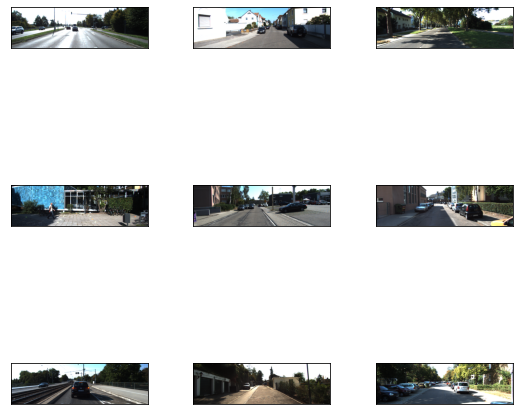

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 2.21,  2.31, -1.55, -1.46, -1.55, -0.64, -0.58], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.20626667, 0.        , 0.45426667, 0.04650564],
       [0.29632   , 0.03760064, 0.49208   , 0.1905153 ],
       [0.44314668, 0.521876  , 0.52610666, 0.55039454],
       [0.46250665, 0.4878744 , 0.54192   , 0.5183011 ],
       [0.47056   , 0.53532207, 0.54096   , 0.5583736 ],
       [0.49658668, 0.74376005, 0.58242667, 0.8199275 ],
       [0.49624   , 0.71700484, 0.57848   , 0.7834138 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.31, 1.6 , 4.09],
       [1.43, 1.58, 3.66],
       [1.37, 1.56, 3.54],
       [1.61, 1.69, 4.26],
       [1.53, 1.63, 4.5 ],
       [1.48, 1.6 , 3.84],
       [1.55, 1.61, 3.64]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array

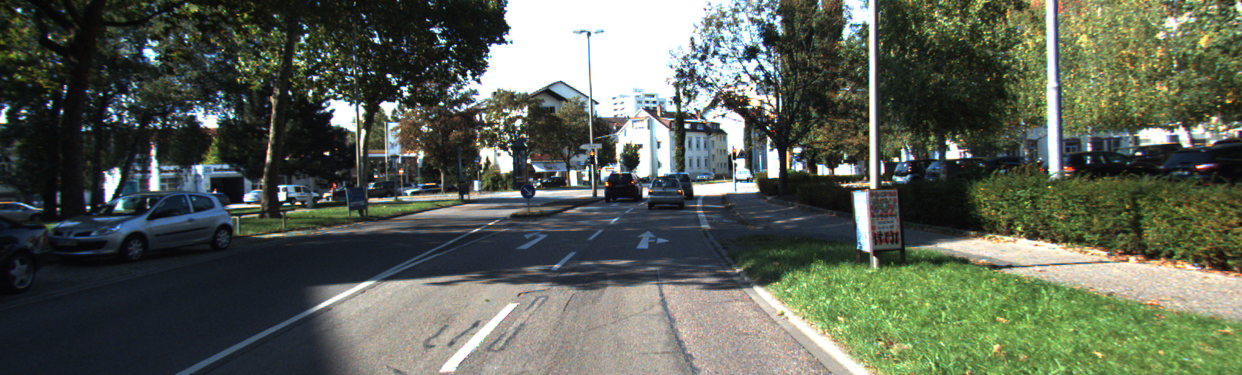

In [5]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

In [6]:
def visualize_bbox(input_image, object_bbox):
    img = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(img)

    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    return img

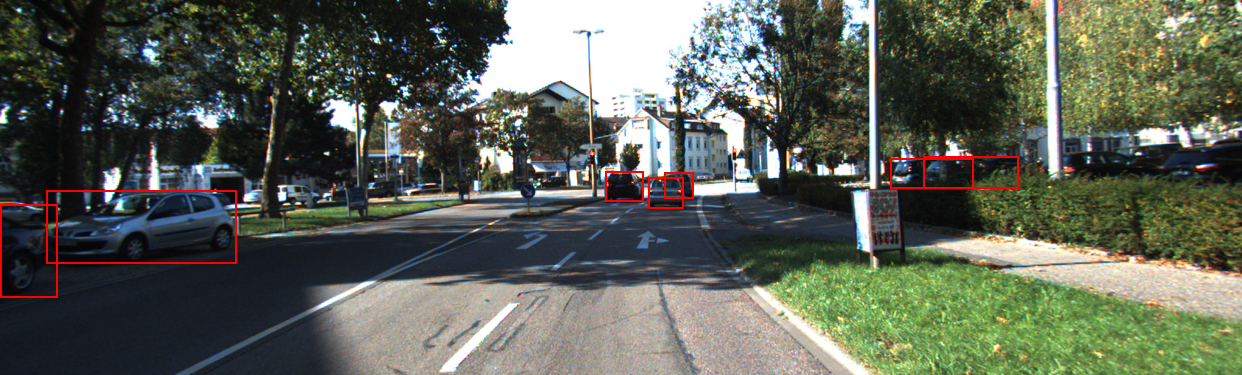

In [7]:
visualize_bbox(img, objects['bbox'].numpy())

In [8]:
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }

    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break

    return df

In [9]:
data_dir = './data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'
test_csv_path = data_dir + '/kitti_test.csv'

In [10]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [11:29<00:00,  9.20it/s]


In [11]:
df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:19<00:00,  8.93it/s]


In [12]:
def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
      
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [13]:
class_txt_path = data_dir + '/classes.txt'
save_class_format(class_txt_path)

## RetinaNet

In [2]:
# epochs 조절
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ./data/classes.txt

2020-10-22 10:13:04.423712: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 10:13:05.359466: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-22 10:13:05.381983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-22 10:13:05.382442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-22 10:13:05.382467: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 10:13:05.383589: I tensorflow/stream_executor/platform

Total params: 36,403,702
Trainable params: 36,297,462
Non-trainable params: 106,240
__________________________________________________________________________________________________
None
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2020-10-22 10:13:14.529048: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2020-10-22 10:13:15.560284: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2020-10-22 10:13:15.609010: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2020-10-22 10:13:15.953762: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-10-22 10:13:35.483978: W tensorflow/cor


Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
195/195 [==============================] - 75s 382ms/step - loss: 1.5792 - regression_loss: 1.2140 - classification_loss: 0.3652
Epoch 15/50
195/195 [==============================] - ETA: 0s - loss: 1.3440 - regression_loss: 1.0290 - classification_loss: 0.3150
Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
195/195 [==============================] - 74s 381ms/step - loss: 1.3440 - regression_loss: 1.0290 - classification_loss: 0.3150
Epoch 16/50
195/195 [==============================] - ETA: 0s - loss: 1.2672 - regression_loss: 0.9803 - classification_loss: 0.2869
Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
195/195 [==============================] - 75s 382ms/step - loss: 1.2672 - regression_loss: 0.9803 - classification_loss: 0.2869
Epoch 17/50
195/195 [==============================] - ETA: 0s - loss: 1.2115 - regression_loss: 0.9344 - classification_loss: 0.2771
Epoch 0001

195/195 [==============================] - ETA: 0s - loss: 1.0924 - regression_loss: 0.8307 - classification_loss: 0.2617
Epoch 00031: saving model to ./snapshots/resnet50_csv_31.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
195/195 [==============================] - 78s 400ms/step - loss: 1.0924 - regression_loss: 0.8307 - classification_loss: 0.2617
Epoch 32/50
195/195 [==============================] - ETA: 0s - loss: 1.0847 - regression_loss: 0.8322 - classification_loss: 0.2524
Epoch 00032: saving model to ./snapshots/resnet50_csv_32.h5
195/195 [==============================] - 78s 401ms/step - loss: 1.0847 - regression_loss: 0.8322 - classification_loss: 0.2524
Epoch 33/50
195/195 [==============================] - ETA: 0s - loss: 1.0519 - regression_loss: 0.7927 - classification_loss: 0.2591
Epoch 00033: saving model to ./snapshots/resnet50_csv_33.h5
195/195 [==============================] - 78s 399ms/step - loss: 1.0519 - regression_loss:

195/195 [==============================] - ETA: 0s - loss: 1.1867 - regression_loss: 0.8937 - classification_loss: 0.2930
Epoch 00047: saving model to ./snapshots/resnet50_csv_47.h5
195/195 [==============================] - 75s 385ms/step - loss: 1.1867 - regression_loss: 0.8937 - classification_loss: 0.2930
Epoch 48/50
195/195 [==============================] - ETA: 0s - loss: 1.0643 - regression_loss: 0.8142 - classification_loss: 0.2501
Epoch 00048: saving model to ./snapshots/resnet50_csv_48.h5

Epoch 00048: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
195/195 [==============================] - 75s 385ms/step - loss: 1.0643 - regression_loss: 0.8142 - classification_loss: 0.2501
Epoch 49/50
195/195 [==============================] - ETA: 0s - loss: 1.0874 - regression_loss: 0.8224 - classification_loss: 0.2650
Epoch 00049: saving model to ./snapshots/resnet50_csv_49.h5
195/195 [==============================] - 75s 385ms/step - loss: 1.0874 - regression_loss:

In [3]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_50.h5 ./snapshots/resnet50_csv_50_infer.h5

2020-10-22 11:17:26.879995: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 11:17:28.157351: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-22 11:17:28.176039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-22 11:17:28.176406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2020-10-22 11:17:28.176426: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-22 11:17:28.178951: I tensorflow/stream_executor/platform

### Inference

In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

gpu = '0'
setup_gpu(gpu)

model_path = './snapshots/resnet50_csv_50_infer.h5'
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1 Physical GPUs, 1 Logical GPUs


In [130]:
def inference_on_image(model, img_path="./data/test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < 0.292:
                break
            b = box.astype(int)
            print(b, score, label)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

[591 176 625 205] 0.7917209 0
[194 132 357 235] 0.34378976 0


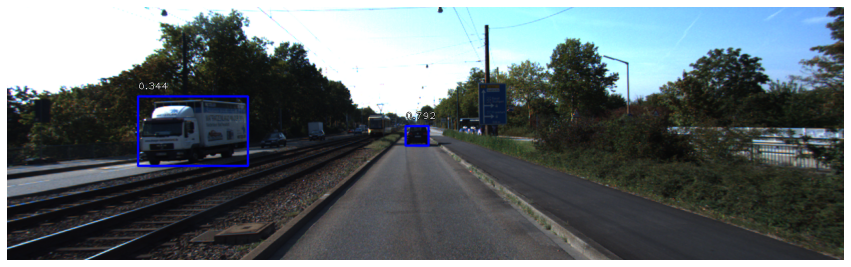

In [131]:
go_img_path = './data/test_set/go_1.png'
inference_on_image(model, img_path=go_img_path)

[773 146 843 313] 0.70565027 1


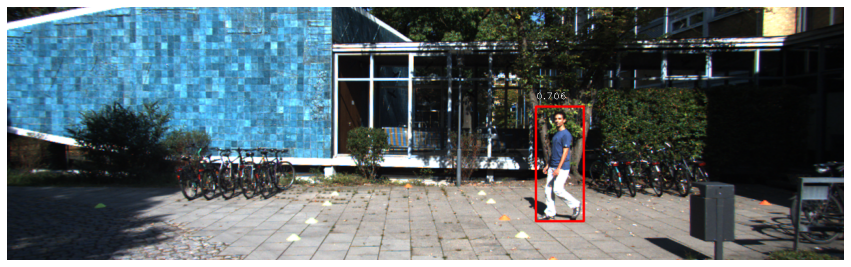

In [132]:
stop_img_path = './data/test_set/stop_1.png'
inference_on_image(model, img_path=stop_img_path)

## Go/Stop Object Detection

In [133]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
    
    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    w = 0
    h = 0

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.29:
                break
        b = box.astype(int)
        # 차량 width, height
        w = b[2]-b[0]
        h = b[3]-b[1]
        
        # 차량의 크기가 limit size를 넘어가거나 사람이 한 명이상 있는지 확인
        if w >= size_limit or h >= size_limit or label==1:
            print(f'width : {w}, height : {h}, score : {score}, label : stop')
            return 'Stop'
        else:
            print(f'width : {w}, height : {h}, score : {score}, label : go')
            return 'Go'

### Test

[591 176 625 205] 0.7917209 0
[194 132 357 235] 0.34378976 0


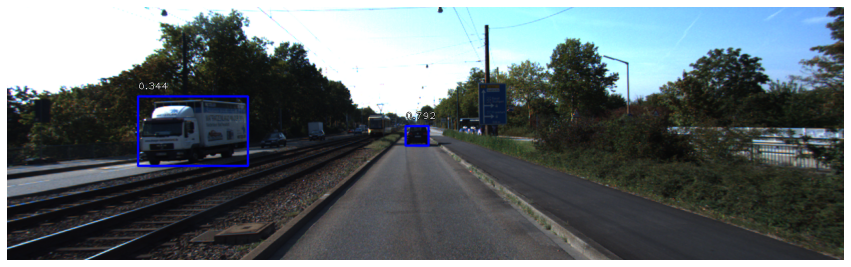

width : 34, height : 29, score : 0.7917209267616272, label : go
Go


In [138]:
test_img_path = './data/test_set/go_1.png'
inference_on_image(model, img_path=test_img_path)
print(self_drive_assist(test_img_path))   

In [139]:
def test_system(func):
    work_dir = './data'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [137]:
test_system(self_drive_assist)

width : 70, height : 167, score : 0.705650269985199, label : stop
width : 88, height : 175, score : 0.6374384164810181, label : stop
width : 318, height : 167, score : 0.7418414354324341, label : stop
width : 373, height : 309, score : 0.5344884991645813, label : stop
width : 360, height : 201, score : 0.5733245611190796, label : stop
width : 34, height : 29, score : 0.7917209267616272, label : go
width : 40, height : 37, score : 0.8117600083351135, label : go
width : 78, height : 29, score : 0.38140368461608887, label : go
width : 91, height : 86, score : 0.5462669730186462, label : go
width : 204, height : 107, score : 0.29297706484794617, label : go
100점입니다.


## Report

KITTI 데이터셋과 RetinaNet을 이용하여 GO/STOP Object detection system을 만들었습니다.  
GO/STOP의 기준은 영상에 사람이 한명이라도 있거나 영상에서 확인되는 차량의 크기가 지정한 limit size보다 큰 경우를 기준으로 합니다.  
낮은 score로 인해 GO/STOP의 정확도가 낮게 측정되었습니다. 그래서 score threshold를 0.29로 낮게 설정하여 정확도를 높였습니다.  